In [39]:
# from sklearn.datasets import load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [49]:
import pandas as pd
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import re
import shap
from lightgbm.sklearn import LGBMClassifier

In [50]:
def preprocess(X, y):
    X = X.copy()
    y = y.copy()
    for col in X.select_dtypes(include=['category']):
        X[col] = X[col].cat.codes
        X.loc[X[col] < 0, col] = np.nan
        X[col] = X[col].astype('category')
    
    X = X[~y.isna()]
    y = y[~y.isna()]
    
    if isinstance(X.columns, pd.MultiIndex):
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
    else:
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', col) for col in X.columns.values]
    return X, y

def get_feature_importances(X, y, return_estimator=False, preprocess=True, clf=None):
    if preprocess:
        X, y = preprocess(X, y)
    
    if clf is None:
        clf = LGBMClassifier(n_jobs=-1)
        clf.fit(X, y)
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X)[:, :, 1]
    if return_estimator:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0), clf
    else:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0)

In [51]:
df = pd.read_pickle('../data/processed/ictcf.pkl')

In [57]:
X, y = preprocess(df.Input.Clinical, df.Target.pcr)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
clf = LGBMClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

LGBMClassifier()

In [87]:
from sklearn.metrics import roc_auc_score
preds = clf.predict_proba(X_test)[:, 1]
preds_orig = (preds-preds.min())/(preds.max()-preds.min())
results = []
for i in range(80):
    for j in range(20):
        preds = preds_orig / 2**i
        preds += np.random.rand()
        results.append({'n': i, 'auc': roc_auc_score(y_test, preds)})
results = pd.DataFrame(results)

<AxesSubplot:xlabel='n', ylabel='auc'>

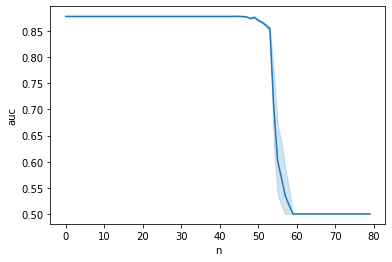

In [88]:
import seaborn as sns
sns.lineplot(data=results, x='n', y='auc')

In [64]:
preds = clf.predict_proba(X_test)[:, 1]
preds = (preds-preds.min())/(preds.max()-preds.min())
preds /= 10
preds += 0.354234
preds.min(), preds.max()

(0.354234, 0.454234)